In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv
/kaggle/input/store-sales-submissions/submission_39331.csv
/kaggle/input/store-sales-submissions/submission_39359.csv
/kaggle/input/store-sales-submissions/submission_39274.csv
/kaggle/input/store-sales-submissions/submission_39369.csv
/kaggle/input/store-sales-submissions/submission_39347.csv
/kaggle/input/store-sales-submissions/submission_39263.csv
/kaggle/input/store-sales-submissions/submission_39281.csv
/kaggle/input/store-sales-submissions/submission_38415.csv
/kaggle/input/store-sales-submissions/submission_39261.csv
/kaggle/input/store-sa

# 1.Model Building and Data Analysis
# 1.Model Oluşturma ve Veri Analizi

#### İmport Necessary Library
#### Gerekli Kütüphaneleri Yükle

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
train_df = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
train_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [36]:
train_df.shape

(3000888, 6)

In [37]:
train_df['date'] = pd.to_datetime(train_df['date'])

#### Veriyi daha iyi anlamak için çeşitli görselleştirmeler yap
#### Make various visualizations to better understand the data

<AxesSubplot:xlabel='sales', ylabel='Count'>

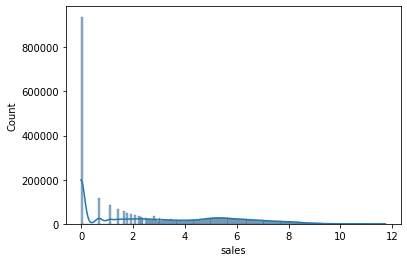

In [38]:
sns.histplot(np.log1p(train_df['sales']), kde=True)

#### by monthly sales according to store_nbr
#### store_nbr'ye göre aylık satışla

Text(0.5, 1.0, "store_nbr'ye göre aylık satışlar")

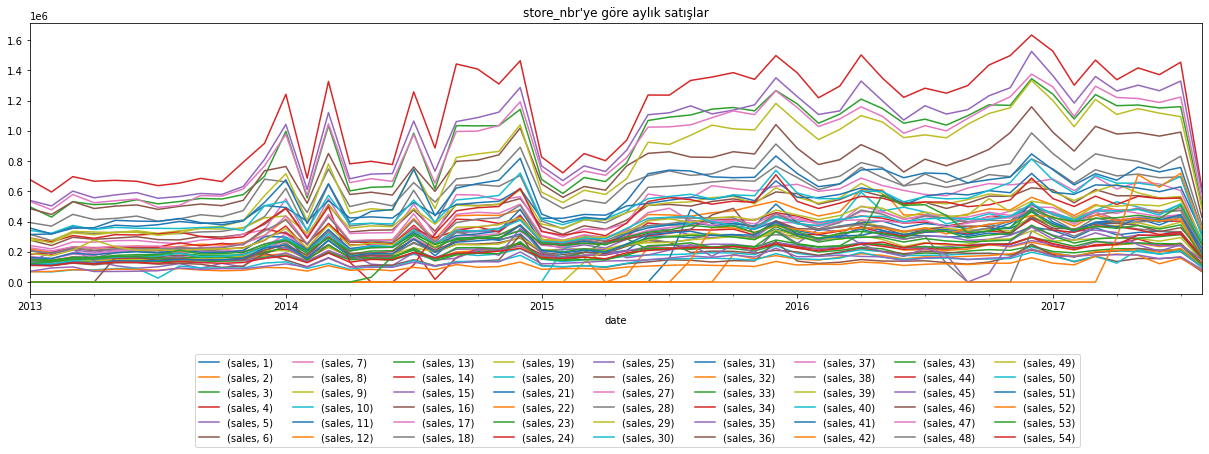

In [39]:
store_nbr_sales_per_month = train_df.groupby(['date', 'store_nbr']).aggregate({'sales': 'sum'}).unstack().resample('1M').sum()
store_nbr_sales_per_month.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(0.9,-.2), ncol=9)
plt.title("store_nbr'ye göre aylık satışlar")

#### Monthly sales by family
#### Aileye göre aylık satışlar

Text(0.5, 1.0, 'Aileye göre aylık satışlar')

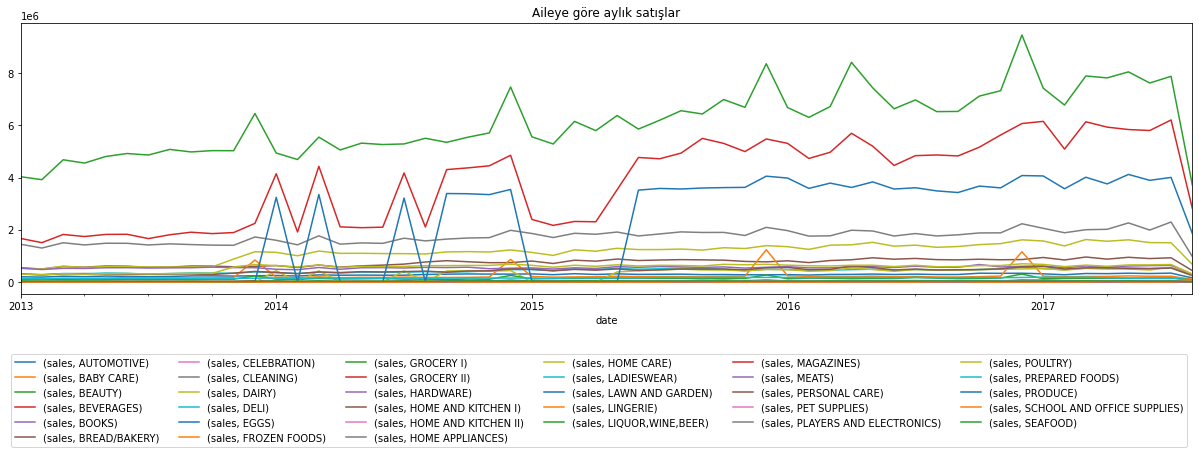

In [40]:
family_sales_per_month = train_df.groupby(['date', 'family']).aggregate({'sales': 'sum'}).unstack().resample('1M').sum()
family_sales_per_month.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(1, -.2), ncol=6)
plt.title("Aileye göre aylık satışlar")

<AxesSubplot:xlabel='onpromotion', ylabel='Count'>

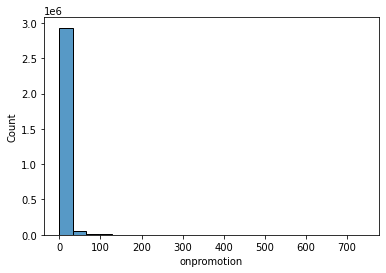

In [41]:
sns.histplot(data=train_df, x='onpromotion')


In [42]:
train_df['sales'] = np.log1p(train_df['sales'])
stores_df = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [43]:
stores_df.shape

(54, 5)

In [44]:
transactions_df = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv')
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [45]:
transactions_df['date'] = pd.to_datetime(transactions_df['date'])
transactions_df.shape


(83488, 3)

#### Monthly transactions by store_nbr
#### Store_nbrye göre aylık işlemler

Text(0.5, 1.0, 'Store_nbrye göre aylık işlemler')

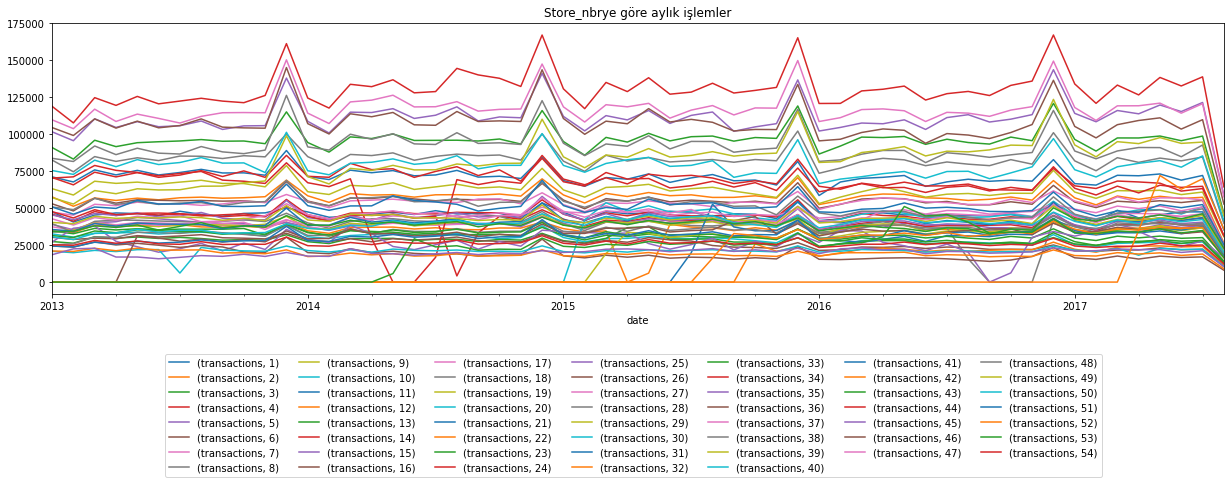

In [46]:
store_nbr_transactions_per_month = transactions_df.groupby(['date', 'store_nbr']).aggregate({'transactions': 'sum'}).unstack().resample('1M').sum()
store_nbr_transactions_per_month.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(0.9,-0.2), ncol=7)
plt.title('Store_nbrye göre aylık işlemler')

In [47]:
test_df = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [48]:
test_id = test_df['id']
test_df['date'] = pd.to_datetime(test_df['date'])

In [49]:
test_df.shape

(28512, 5)

In [50]:
holidays_df = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv')
holidays_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [51]:
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

In [52]:
holidays_df.shape

(350, 6)

In [53]:
oil_df = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [54]:
oil_df['dcoilwtico'].fillna(method='backfill', inplace=True)
oil_df['date'] = pd.to_datetime(oil_df['date'])
oil_df.shape

(1218, 2)

Text(0.5, 1.0, 'Petrol fiyatı')

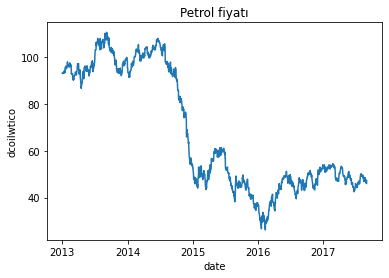

In [55]:
sns.lineplot(data=oil_df, x='date', y='dcoilwtico')
plt.title('Petrol fiyatı')

#### Fonksiyon yardımıyla hızlı veri okuma 
#### Fast data reading with the help of the function

In [56]:
def lag_features(df, lags):
    for lag in lags:
        df[f"sales_t-{lag}"] = df.groupby(["store_nbr", "family"])["sales"].transform(
            lambda x: x.shift(lag))
    return df

In [57]:
def fill_na(df):
    df['holiday_type'] = df['holiday_type'].fillna('Common')
    df['locale'] = df['locale'].fillna('Common')
    df['description'] = df['description'].fillna('Unknown')
    df['transferred'] = df['transferred'].fillna(False)
    df['dcoilwtico'] = df['dcoilwtico'].fillna(method='backfill')
    return df

In [58]:
def merge_data(df):
    df = df \
        .merge(stores_df, left_on="store_nbr", right_on="store_nbr", how="left") \
        .rename(columns={"type": "store_type"}) \
        .merge(transactions_df, left_on=["date", "store_nbr"], right_on=["date", "store_nbr"], how="left") \
        .merge(holidays_df, left_on="date", right_on="date", how="left") \
        .drop_duplicates(subset="id") \
        .rename(columns={"type": "holiday_type"}) \
        .merge(oil_df, left_on="date", right_on="date", how="left") 
    return df

In [59]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    return df

In [60]:
def random_noise(dataframe):
    return np.random.normal(scale=2.0, size=(len(dataframe),))

In [61]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store_nbr", "family"])['sales']. \
                                                          transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=7, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [62]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [63]:
col = [
    'date',
    'store_nbr', 
    'family', 
    'sales', 
    'onpromotion', 
    'cluster', 
    'holiday_type', 
    'locale', 
    'description', 
    'transferred',
    'dcoilwtico'
]

In [64]:
all_df = pd.concat([train_df, test_df], axis=0)
all_df = merge_data(all_df)
all_df = all_df[col]
all_df = fill_na(all_df)
all_df = create_date_features(all_df)
all_df = lag_features(all_df, lags = [*range(1, 16), 16,17,18,19,20,21,22,30,31,90,180,364])
all_df = roll_mean_features(all_df,[16,17,18,30])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [65]:
alphas = [0.95, 0.9, 0.8, 0.5]
lags =[1, 7,30]
all_df = ewm_features(all_df, alphas, lags)

In [66]:
all_df['store_nbr'] = all_df['store_nbr'].astype('category')
all_df['family'] = all_df['family'].astype('category')
all_df['store_nbr'] = all_df['store_nbr'].astype('category')
all_df['cluster'] = all_df['cluster'].astype('category')
all_df['family'] = all_df['family'].astype('category')
all_df['holiday_type'] = all_df['holiday_type'].astype('category')
all_df['locale'] = all_df['locale'].astype('category')
all_df['description'] = all_df['description'].astype('category')

In [67]:
all_df

,date,store_nbr,family,sales,onpromotion,cluster,holiday_type,locale,description,transferred,...,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_09_lag_1,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30
0,2013-01-01,1,AUTOMOTIVE,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,1,BOOKS,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,6,Common,Common,Unknown,False,...,6.338358,6.045064,6.045064,6.329319,6.012643,6.012643,6.311631,5.957384,5.957384,6.244803
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,6,Common,Common,Unknown,False,...,3.953042,5.016271,5.016271,3.969407,4.984993,4.984993,4.014010,4.894600,4.894600,4.210488
3029397,2017-08-31,9,PRODUCE,NaN,1,6,Common,Common,Unknown,False,...,7.788738,7.735485,7.735485,7.765895,7.682595,7.682595,7.722496,7.532320,7.532320,7.590557
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,6,Common,Common,Unknown,False,...,5.253514,4.845138,4.845138,5.186784,4.885929,4.885929,5.043656,4.982981,4.982981,4.438414


In [68]:
all_df = all_df.query("date > '2013-12-31'")
X = all_df.query("date <= '2017-08-15'")
X_test = all_df.query("date > '2017-08-15'")
X.drop(['date'], inplace=True, axis=1)
X_test.drop(['date', 'year'], inplace=True, axis=1)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [69]:
corr = X.corr()
corr['sales'].sort_values(ascending=False)

sales                         1.000000
sales_ewm_alpha_05_lag_1      0.973090
sales_ewm_alpha_08_lag_1      0.968657
sales_ewm_alpha_05_lag_7      0.966604
sales_ewm_alpha_09_lag_1      0.966508
sales_ewm_alpha_095_lag_1     0.965262
sales_ewm_alpha_08_lag_7      0.964625
sales_t-1                     0.963883
sales_ewm_alpha_09_lag_7      0.963186
sales_ewm_alpha_095_lag_7     0.962281
sales_t-7                     0.961233
sales_t-2                     0.958115
sales_t-3                     0.955286
sales_t-4                     0.953452
sales_t-6                     0.953263
sales_t-5                     0.952700
sales_t-14                    0.949117
sales_t-8                     0.949008
sales_t-9                     0.944701
sales_t-10                    0.942176
sales_t-13                    0.941201
sales_t-11                    0.940818
sales_t-12                    0.940049
sales_t-15                    0.937474
sales_t-21                    0.937108
sales_t-16               

In [70]:
Y = X['sales']
X = X.drop(['sales', 'year'], axis=1)
X_test = X_test.drop(['sales'], axis=1)

In [71]:
X.shape, Y.shape, X_test.shape

((2352240, 57), (2352240,), (28512, 57))

In [72]:
#!pip install lightgbm
#!pip install catboost

# Model Building with CatBoostRegressor 
# CatBoostRegressor ile Model Oluşturma

In [73]:
import catboost as cb
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

In [74]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [75]:
X_train.dtypes

store_nbr                     category
family                        category
onpromotion                      int64
cluster                       category
holiday_type                  category
locale                        category
description                   category
transferred                       bool
dcoilwtico                     float64
month                            int64
day_of_month                     int64
day_of_year                      int64
week_of_year                     int64
day_of_week                      int64
sales_t-1                      float64
sales_t-2                      float64
sales_t-3                      float64
sales_t-4                      float64
sales_t-5                      float64
sales_t-6                      float64
sales_t-7                      float64
sales_t-8                      float64
sales_t-9                      float64
sales_t-10                     float64
sales_t-11                     float64
sales_t-12               

In [76]:
def recursive_predict(model):
    global X_test
    output = np.array([])
    for day in range(16, 32):
        pred = model.predict(X_test.query(f"day_of_month == {day}"))
        pred[pred < 0] = 0
        output = np.concatenate([output, pred], axis=0)
        for k in range(day+1, 32):
            X_test.loc[X_test[X_test["day_of_month"] == k].index, f"sales_t-{k-day}"] = pred
    return output

In [77]:
lgb_params={
    "metric":"mse",
    "boosting_type":"gbdt",
    "num_leaves":8,
    "learning_rate":0.2,
    "max_depth":7,
    "verbose":0,
    "num_boost_round":5000,
    "early_stopping_rounds":200,
    "nthread":-1,
    "force_col_wise":True,
}

In [78]:
train_dataset = lgb.Dataset(data=X_train, label=Y_train, feature_name='auto')
val_dataset = lgb.Dataset(data=X_val, label=Y_val, reference=train_dataset, feature_name='auto')

In [79]:
model=lgb.train(
    params=lgb_params,
    train_set=train_dataset,
    valid_sets=[train_dataset,val_dataset],
    verbose_eval=100)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.173083	valid_1's l2: 0.175914
[200]	training's l2: 0.159952	valid_1's l2: 0.163075
[300]	training's l2: 0.153836	valid_1's l2: 0.157343
[400]	training's l2: 0.149647	valid_1's l2: 0.153455
[500]	training's l2: 0.146667	valid_1's l2: 0.150805
[600]	training's l2: 0.144304	valid_1's l2: 0.148788
[700]	training's l2: 0.142109	valid_1's l2: 0.14688
[800]	training's l2: 0.140493	valid_1's l2: 0.145551
[900]	training's l2: 0.138922	valid_1's l2: 0.144304
[1000]	training's l2: 0.137608	valid_1's l2: 0.143246
[1100]	training's l2: 0.13651	valid_1's l2: 0.142468
[1200]	training's l2: 0.135526	valid_1's l2: 0.141818
[1300]	training's l2: 0.134475	valid_1's l2: 0.141182
[1400]	training's l2: 0.133642	valid_1's l2: 0.140678
[1500]	training's l2: 0.132876	valid_1's l2: 0.140213
[1600]	training's l2: 0.132018	valid_1's l2: 0.139757
[1700]	training's l2: 0.131322	valid_1's l2: 0.139402
[1800]	training's l2: 0.130684	

In [80]:
Y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
Y_val_pred[Y_val_pred < 0] = 0

In [81]:
print(np.sqrt(mean_squared_error(Y_val, Y_val_pred)))
print(mean_squared_log_error(np.expm1(Y_val), np.expm1(Y_val_pred)))

0.3662942507956056
0.13417147816591402


In [82]:
cat_indices = np.where(X_train.dtypes == 'category')[0]
train_dataset_cb = cb.Pool(X_train, Y_train, cat_features=cat_indices)
val_dataset_cb = cb.Pool(X_val, Y_val, cat_features=cat_indices)

model_cb = CatBoostRegressor(
    loss_function='RMSE',
    cat_features=cat_indices,
    max_depth=7,
    n_estimators=100
)
model_cb.fit(train_dataset_cb, eval_set=val_dataset_cb)

Learning rate set to 0.5
0:	learn: 1.4628983	test: 1.4626866	best: 1.4626866 (0)	total: 1.39s	remaining: 2m 17s
1:	learn: 0.8812822	test: 0.8823942	best: 0.8823942 (1)	total: 2.46s	remaining: 2m
2:	learn: 0.6365314	test: 0.6379357	best: 0.6379357 (2)	total: 3.51s	remaining: 1m 53s
3:	learn: 0.5459554	test: 0.5476304	best: 0.5476304 (3)	total: 4.71s	remaining: 1m 52s
4:	learn: 0.5151817	test: 0.5170111	best: 0.5170111 (4)	total: 5.75s	remaining: 1m 49s
5:	learn: 0.5005485	test: 0.5025834	best: 0.5025834 (5)	total: 6.83s	remaining: 1m 47s
6:	learn: 0.4891149	test: 0.4910767	best: 0.4910767 (6)	total: 7.91s	remaining: 1m 45s
7:	learn: 0.4818291	test: 0.4835570	best: 0.4835570 (7)	total: 8.96s	remaining: 1m 43s
8:	learn: 0.4754522	test: 0.4771843	best: 0.4771843 (8)	total: 9.94s	remaining: 1m 40s
9:	learn: 0.4706879	test: 0.4728408	best: 0.4728408 (9)	total: 10.8s	remaining: 1m 37s
10:	learn: 0.4649663	test: 0.4671142	best: 0.4671142 (10)	total: 11.7s	remaining: 1m 34s
11:	learn: 0.4606389

In [83]:
rec_pred_cb = recursive_predict(model_cb)

In [84]:
X_test = all_df.query("date > '2017-08-15'")
X_test.drop(['date', 'year', 'sales'], inplace=True, axis=1)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [85]:
X_test = all_df.query("date > '2017-08-15'")
X_test.drop(['date', 'year', 'sales'], inplace=True, axis=1)

In [86]:
Y_val_pred_cb = model_cb.predict(X_val)
Y_val_pred_cb[Y_val_pred_cb < 0] = 0

In [87]:
print(np.sqrt(mean_squared_error(Y_val, Y_val_pred_cb)))
print(mean_squared_log_error(np.expm1(Y_val), np.expm1(Y_val_pred_cb)))

0.3993834403131355
0.15950713239635586


In [88]:
rec_pred_cb = recursive_predict(model_cb)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [89]:
rec_pred_lgb = recursive_predict(model)

In [90]:
solution = pd.DataFrame({'id': test_id, 'sales': np.expm1(rec_pred_lgb)})
solution.to_csv('submission1_1.csv', index=False)

# 2.Model Building And Data Analysis 
# 2.Model Oluşturma ve Veri Analizi

## İmport Necessary Library
## Gerekli Kütüphaneleri Yükle

In [91]:
import numpy as np
import pandas as pd
from random import random
import os

from sklearn.metrics import mean_squared_log_error as msle
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm

from matplotlib import pyplot as plt, style
style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
from tqdm import tqdm

from pandas_profiling import ProfileReport

import gc
gc.enable()
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

In [92]:
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv', parse_dates = ['date'], infer_datetime_format = True, index_col=['id'])

In [93]:
test['date'] = test.date.dt.to_period('D')

In [94]:
df_pred = test.copy()

#### Return files quickly with function
#### Fonksiyon ile dosyaları hızlı şekilde dön

In [95]:
for dirname, _, filenames in os.walk('/kaggle/input/store-sales-submissions'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        df_pred['sub_'+filename.split('_')[1].split('.')[0]] = pd.read_csv(os.path.join(dirname, filename), index_col=['id']).sales


/kaggle/input/store-sales-submissions/submission_39331.csv
/kaggle/input/store-sales-submissions/submission_39359.csv
/kaggle/input/store-sales-submissions/submission_39274.csv
/kaggle/input/store-sales-submissions/submission_39369.csv
/kaggle/input/store-sales-submissions/submission_39347.csv
/kaggle/input/store-sales-submissions/submission_39263.csv
/kaggle/input/store-sales-submissions/submission_39281.csv
/kaggle/input/store-sales-submissions/submission_38415.csv
/kaggle/input/store-sales-submissions/submission_39261.csv
/kaggle/input/store-sales-submissions/submission_39262.csv
/kaggle/input/store-sales-submissions/submission_38558.csv
/kaggle/input/store-sales-submissions/submission_39266.csv


In [96]:
df_pred.head()

,date,store_nbr,family,onpromotion,sub_39331,sub_39359,sub_39274,sub_39369,sub_39347,sub_39263,sub_39281,sub_38415,sub_39261,sub_39262,sub_38558,sub_39266
id,,,,,,,,,,,,,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0,3.657460,3.575363,3.680601,3.602805,3.602805,3.602805,3.572214,3.453666,3.602805,3.602805,3.128176,3.602805
3000889,2017-08-16,1,BABY CARE,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3000890,2017-08-16,1,BEAUTY,2,5.143072,4.705614,4.481895,4.550604,4.550604,4.550604,4.667599,4.695971,4.550604,4.550604,4.239227,4.550604
3000891,2017-08-16,1,BEVERAGES,20,2289.104965,2254.839529,2256.487200,2256.487200,2256.487200,2256.487200,2256.487200,2301.266606,2256.487200,2256.487200,2359.855324,2256.487205
3000892,2017-08-16,1,BOOKS,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Pandas Profil ile kolayca verileri incele 
#### Examine data easily with Pandas Profile

In [97]:
test_profile = ProfileReport(test, title="test_profile")
test_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [98]:
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv', parse_dates = ['date'], infer_datetime_format = True, index_col=['id'])
test['date'] = test.date.dt.to_period('D')

df_pred = test.copy()

In [99]:
for dirname, _, filenames in os.walk('/kaggle/input/store-sales-submissions'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        df_pred['sub_'+filename.split('_')[1].split('.')[0]] = pd.read_csv(os.path.join(dirname, filename), index_col=['id']).sales

df_pred.head()

/kaggle/input/store-sales-submissions/submission_39331.csv
/kaggle/input/store-sales-submissions/submission_39359.csv
/kaggle/input/store-sales-submissions/submission_39274.csv
/kaggle/input/store-sales-submissions/submission_39369.csv
/kaggle/input/store-sales-submissions/submission_39347.csv
/kaggle/input/store-sales-submissions/submission_39263.csv
/kaggle/input/store-sales-submissions/submission_39281.csv
/kaggle/input/store-sales-submissions/submission_38415.csv
/kaggle/input/store-sales-submissions/submission_39261.csv
/kaggle/input/store-sales-submissions/submission_39262.csv
/kaggle/input/store-sales-submissions/submission_38558.csv
/kaggle/input/store-sales-submissions/submission_39266.csv


,date,store_nbr,family,onpromotion,sub_39331,sub_39359,sub_39274,sub_39369,sub_39347,sub_39263,sub_39281,sub_38415,sub_39261,sub_39262,sub_38558,sub_39266
id,,,,,,,,,,,,,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0,3.657460,3.575363,3.680601,3.602805,3.602805,3.602805,3.572214,3.453666,3.602805,3.602805,3.128176,3.602805
3000889,2017-08-16,1,BABY CARE,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3000890,2017-08-16,1,BEAUTY,2,5.143072,4.705614,4.481895,4.550604,4.550604,4.550604,4.667599,4.695971,4.550604,4.550604,4.239227,4.550604
3000891,2017-08-16,1,BEVERAGES,20,2289.104965,2254.839529,2256.487200,2256.487200,2256.487200,2256.487200,2256.487200,2301.266606,2256.487200,2256.487200,2359.855324,2256.487205
3000892,2017-08-16,1,BOOKS,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### all submissions are highly correlated
#### tüm gönderimler yüksek oranda ilişkilidir

<AxesSubplot:>

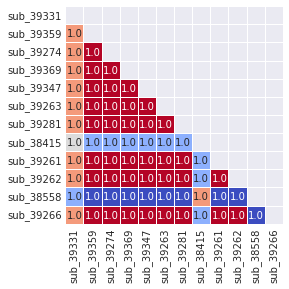

In [100]:
res = df_pred.drop(['store_nbr','onpromotion'], axis=1).groupby('family').mean()
res_corr = res.corr(method="spearman")
sns.heatmap(res_corr, annot=True, fmt='.1f', cmap='coolwarm', square=True, mask=np.triu(res_corr), linewidths=1, cbar=False)

#### Upgini only notebooks
#### Sadece Upgini not defterleri

In [101]:
pred_cols = ['sub_39331','sub_39359','sub_39274','sub_39369','sub_39347','sub_39263','sub_39281','sub_39261','sub_39262','sub_39266']

In [102]:
def func(dt):
    pred_res = pd.Series()
    for col in pred_cols:
        pred_res[col] = np.sqrt(np.sqrt(msle(dt[col], dt['sub_38558'])))
    return pred_res

####  "min" - is the column name with the predicted values closest to the best Darts "38558" submission
####  "min" - en iyi Dart "38558" gönderimine en yakın tahmin edilen değerlere sahip sütun adıdır

In [103]:
res = df_pred.groupby('family').apply(func)
res['min'] = res.idxmin(axis=1)
res

,sub_39331,sub_39359,sub_39274,sub_39369,sub_39347,sub_39263,sub_39281,sub_39261,sub_39262,sub_39266,min
family,,,,,,,,,,,
AUTOMOTIVE,0.374518,0.365258,0.364328,0.366008,0.366008,0.366008,0.364750,0.366008,0.366008,0.366010,sub_39274
BABY CARE,0.339326,0.328387,0.327605,0.327236,0.327236,0.327236,0.328600,0.327236,0.327236,0.327236,sub_39369
BEAUTY,0.476809,0.503078,0.502813,0.505084,0.505084,0.505084,0.503247,0.505084,0.505084,0.505084,sub_39331
BEVERAGES,0.315451,0.294803,0.295091,0.295091,0.295091,0.295091,0.295091,0.295091,0.295091,0.295087,sub_39359
BOOKS,0.212598,0.220923,0.221485,0.215813,0.212895,0.221291,0.221291,0.221485,0.221485,0.221485,sub_39331
BREAD/BAKERY,0.245458,0.255558,0.255917,0.255917,0.255917,0.255917,0.255917,0.255917,0.255917,0.255917,sub_39331
CELEBRATION,0.420220,0.408199,0.407565,0.408939,0.408939,0.408939,0.407741,0.408939,0.408939,0.408940,sub_39274
CLEANING,0.400930,0.380050,0.380682,0.387082,0.387082,0.387082,0.380431,0.386797,0.387082,0.386797,sub_39359
DAIRY,0.255023,0.271100,0.271701,0.271701,0.271701,0.271701,0.271701,0.271701,0.271701,0.271695,sub_39331


In [104]:
res['min'].value_counts()

sub_39331    13
sub_39359    10
sub_39274     4
sub_39266     4
sub_39369     2
Name: min, dtype: int64

<AxesSubplot:xlabel='date'>

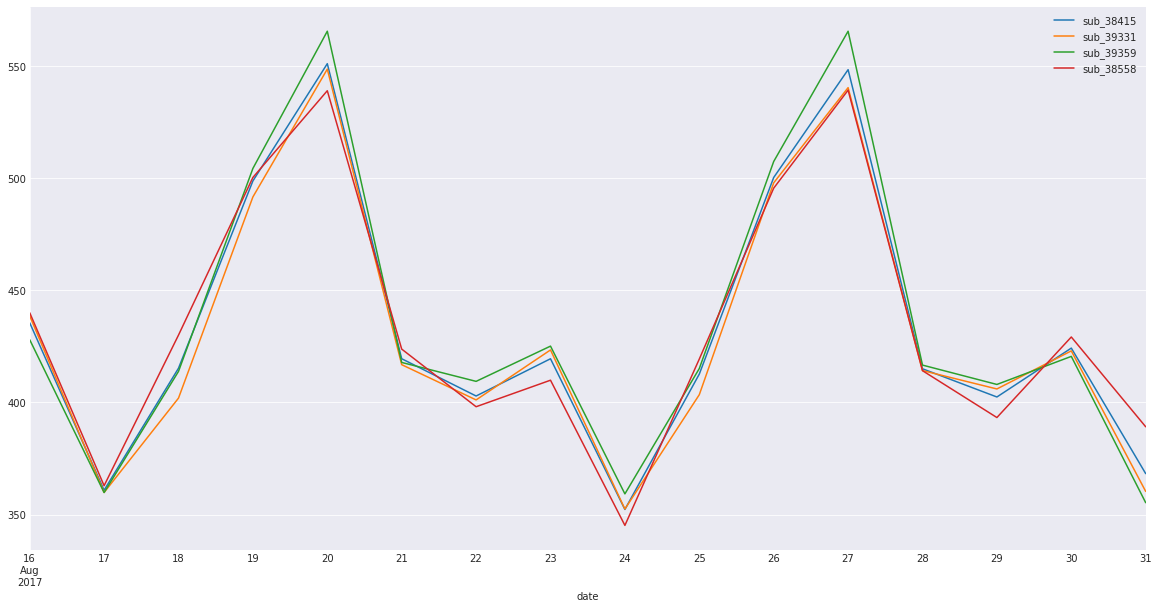

In [105]:
res = df_pred.groupby('date')[['sub_38415','sub_39331','sub_39359','sub_38558']].mean()
res.plot(figsize=(20,10))

#### stack the closest 3 submissions ['sub_39331','sub_39359','sub_38558'] - has the best score!
#### en yakın 3 gönderimi bir araya getirin ['sub_39331','sub_39359','sub_38558'] - en iyi skora sahip!

In [106]:
sub = pd.DataFrame(df_pred[['sub_39331','sub_39359','sub_38558']].mean(axis=1), columns=['sales']).reset_index()
sub.to_csv('submission_38558.csv', index = False)

#### en yakın 3 gönderimi yığın ['sub_38415','sub_39331','sub_39359'] - diğer 2 yakın çözümle önceki en iyi skor
#### stack the closest 3 submissions ['sub_38415','sub_39331','sub_39359'] - the previous best score with 2 other closest solutions

In [107]:
sub = pd.DataFrame(df_pred[['sub_38415','sub_39331','sub_39359']].mean(axis=1), columns=['sales']).reset_index()
sub.to_csv('submission_38415.csv', index = False)

#### en iyi 2 gönderimi istifleyin 
#### stack the 2 best submissions


In [108]:
sub = pd.DataFrame(df_pred[['sub_38415','sub_38558']].mean(axis=1), columns=['sales']).reset_index()
sub.to_csv('submission.csv', index = False)

In [109]:
sub_cols = pred_cols + ['sub_38558']

sub = pd.DataFrame(df_pred[sub_cols].mean(axis=1), columns=['sales']).reset_index()
sub.to_csv('submission_mean.csv', index = False)

#### mevcut tüm gönderimleri istifleyin
#### stack all existing submissions 


In [110]:
sub = pd.DataFrame(df_pred[pred_cols].mean(axis=1), columns=['sales']).reset_index()
sub.to_csv('submission2_pred.csv', index = False)